#### Datasets required:

`modis_ctt_ctp.nc`; `era5_case_study.nc`; `ds_era5_vars.nc`; `ds_era5_flux.nc`


In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import time
import cmocean.cm as cmo
from functions import plot_params
import numpy as np

import cartopy
import cartopy.crs as ccrs
import matplotlib.path as mpath
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#### Load the cloud top pressure and ERA5 vars for the case study day

In [2]:
# load the relevant day for the storm analysis

ds = xr.open_dataset('/home/mduplessis/data/satellite_ctp/processed/modis_ctt_ctp.nc')

In [3]:
# load era5 data that covers the vast array of the atlantic ocean

# era5 = xr.open_mfdataset('/Volumes/LaCie/Work/data/era5/DJFM_2018_19_hourly_means/*201901.nc').load()

# era5_day = era5.sel(time='2019-01-04T20:00:00')

# era5_day.to_netcdf('../../data/era5/era5_case_study.nc')

In [ ]:
# load era5 data for the case study

# era5_day = xr.open_dataset('/home/mduplessis/data/era5/era5_case_study.nc')

#### Load era5 data that covers a smaller array of the atlantic ocean 

In [3]:
# load era5 data that covers a smaller array of the atlantic ocean 

ds_era5_vars = xr.open_dataset('/home/mduplessis/data/era5/ds_era5_vars.nc').load()
ds_era5_flux = xr.open_dataset('/home/mduplessis/data/era5/ds_era5_flux.nc').load()

print('merging')

ds_era5_atl = xr.merge([ds_era5_vars, ds_era5_flux])

merging


In [4]:
# determine the day of year variable for the various datasets

import matplotlib.dates as mdates

day0=mdates.date2num(np.datetime64('2019-01-01 00:00:00'))

In [5]:
# process the era5 dataset

ds_era5_atl['sp'] = (('time', 'latitude', 'longitude'), ds_era5_atl['sp'].data/100)

ds_era5_atl['wnd'] = (('time', 'latitude', 'longitude'), np.sqrt(ds_era5_atl['u10']**2 + ds_era5_atl['v10']**2).data)

ds_era5_site = ds_era5_atl.sel(longitude=0, latitude=-54)

import matplotlib.dates as mdates

ds_era5_site['DOY']=(('time'), mdates.date2num(ds_era5_site.time)-day0)

ds_era5_site['qnet'] = (('time'), ds_era5_site['sshf'].data + ds_era5_site['slhf'].data + ds_era5_site['str'].data + ds_era5_site['ssr'].data)

ds_era5_site['sthf'] = (('time'), ds_era5_site.sshf.data + ds_era5_site.slhf.data)

import functions.dewpoint_to_rh as dp2rh

ds_era5_site = dp2rh.convert_dp_to_rh(ds_era5_site)

ds_era5_site['dt'] = (('time'), ds_era5_site['t2m'].data - ds_era5_site['sst'].data)

sl_xld  = xr.open_dataset('/home/mduplessis/data/slocum/slocum_xld.nc')

ds_era5_site = ds_era5_site.sel(time=slice(sl_xld.time.data[0], sl_xld.time.data[-1]))

from functions.wind_direction_from_uv import wind_direction

wd = [wind_direction(ds_era5_site.v10.data[i], ds_era5_site.u10.data[i]) for i in range(ds_era5_site.time.size)]

ds_era5_site['wnd_dir'] = (('time'), np.array(wd))


In [6]:
# calculate the specific humidity

from functions.calculate_specific_humidity import calculate_specific_humidity

ds_era5_site['sh'] = (('time'), calculate_specific_humidity(ds_era5_site['t2m'].data-273.15, ds_era5_site['rh'].data))

In [7]:
# calculate fluxes in 20 degree wind directions bins

# remove known warnings 

import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

def calculate_stats(ds, var, wind_dir_grid):

    mean_data = []
    std_data = []

    for i, val in enumerate(wind_dir_grid):

        idx = ((ds.wnd_dir.data > val) & (ds.wnd_dir.data < val + 20))

        mean_data += np.mean(ds[var].data[idx]),
        # std_data += np.std(ds[var].data[idx]),
        std_data += np.std(ds[var].data[idx]) / np.sqrt(len(ds[var].data[idx])),
    

    return np.array(mean_data), np.array(std_data)

wind_dir_grid = np.arange(0, 380, 20)

shf_mean_wnd_dir, shf_std_wnd_dir = calculate_stats(ds_era5_site, 'sshf', wind_dir_grid)
lhf_mean_wnd_dir, lhf_std_wnd_dir = calculate_stats(ds_era5_site, 'slhf', wind_dir_grid)
thf_mean_wnd_dir, thf_std_wnd_dir = calculate_stats(ds_era5_site, 'sthf', wind_dir_grid)
str_mean_wnd_dir, str_std_wnd_dir = calculate_stats(ds_era5_site, 'str',  wind_dir_grid)
ssr_mean_wnd_dir, ssr_std_wnd_dir = calculate_stats(ds_era5_site, 'ssr',  wind_dir_grid)
wnd_mean_wnd_dir, wnd_std_wnd_dir = calculate_stats(ds_era5_site, 'wnd',  wind_dir_grid)
sh_mean_wnd_dir,  sh_std_wnd_dir  = calculate_stats(ds_era5_site, 'sh',   wind_dir_grid)
dt_mean_wnd_dir,  dt_std_wnd_dir  = calculate_stats(ds_era5_site, 'dt',   wind_dir_grid)

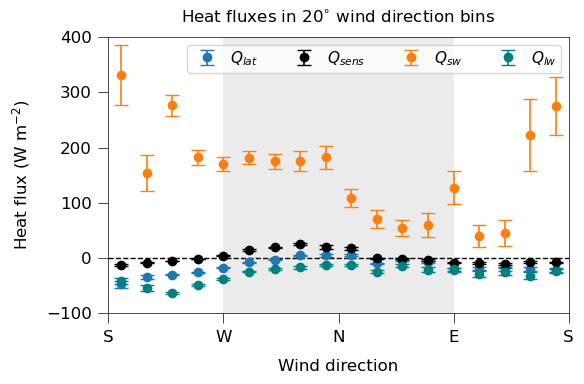

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# add northerly wind shading
ax.fill_betweenx(x1=90, x2=270, y=[-100, 400], facecolor='0.85', zorder=0, alpha=0.5)

ms = 6
cs = 5

# Latent heat flux
ax.errorbar(wind_dir_grid + 10, lhf_mean_wnd_dir, yerr=lhf_std_wnd_dir, linestyle='None', marker='o', markersize=ms, capsize=cs, zorder=0, color='tab:blue', label='$Q_{lat}$')
# Sensible heat flux
ax.errorbar(wind_dir_grid + 10, shf_mean_wnd_dir, yerr=shf_std_wnd_dir, linestyle='None', marker='o', markersize=ms, capsize=cs, zorder=0, color='k', label='$Q_{sens}$', alpha=1)

# Latent heat flux
ax.errorbar(wind_dir_grid + 10, ssr_mean_wnd_dir, yerr=ssr_std_wnd_dir, linestyle='None', marker='o', markersize=ms, capsize=cs, zorder=0, color='tab:orange', label='$Q_{sw}$')
# Sensible heat flux
ax.errorbar(wind_dir_grid + 10, str_mean_wnd_dir, yerr=str_std_wnd_dir, linestyle='None', marker='o', markersize=ms, capsize=cs, zorder=0, color='teal', label='$Q_{lw}$', alpha=1)

# Set axis limits and ticks
ax.set_ylim(-100, 400)
ax.set_xlim(0, 360)
# ax.yaxis.set_ticks(np.arange(-60, 80, 20))
ax.xaxis.set_ticks([0, 90, 180, 270, 360])
ax.xaxis.set_ticklabels(['S', 'W', 'N', 'E', 'S'])
ax.set_xlabel('Wind direction', labelpad=10)
ax.set_ylabel('Heat flux (W m$^{-2}$)', labelpad=10)

ax.set_title('Heat fluxes in 20$^{\circ}$ wind direction bins', fontsize=12, pad=10)

# Customize legend
ax.legend(fontsize=11, ncol=4, frameon=True, loc='upper right', bbox_to_anchor=(1, 1.0), handleheight=1, handletextpad=0.5, borderpad=0.3)

# Remove spines
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# Add a horizontal dashed line
ax.axhline(c='k', zorder=0, ls='--', lw=1)

# Adjust layout and save figure
fig.tight_layout()

# plt.savefig('../../figs/figure-3c.png', dpi=300)



#### Figure 3

In [8]:
era5_day = ds_era5_atl.sel(time='2019-01-04T17:00:00')

In [9]:
storms_soscex = xr.open_dataset('/home/mduplessis/data/storms/storms_soscex.nc')

In [10]:
storm_day = storms_soscex.time.isel(time=215)

In [11]:
from geopy.distance import geodesic

def get_circle_points(center, radius_km, num_points=100):
    angles = np.linspace(0, 360, num_points)
    circle_points = []
    for angle in angles:
        destination = geodesic(kilometers=radius_km).destination(center, angle)
        circle_points.append((destination.latitude, destination.longitude))
    return circle_points

# Draw a circle around the storm center
circle_points = get_circle_points((storm_day.lat.values, storm_day.lon.values), 1000)
lats, lons = zip(*circle_points)
        

In [12]:
font = {'size': 10}
plt.rc('font', **font)

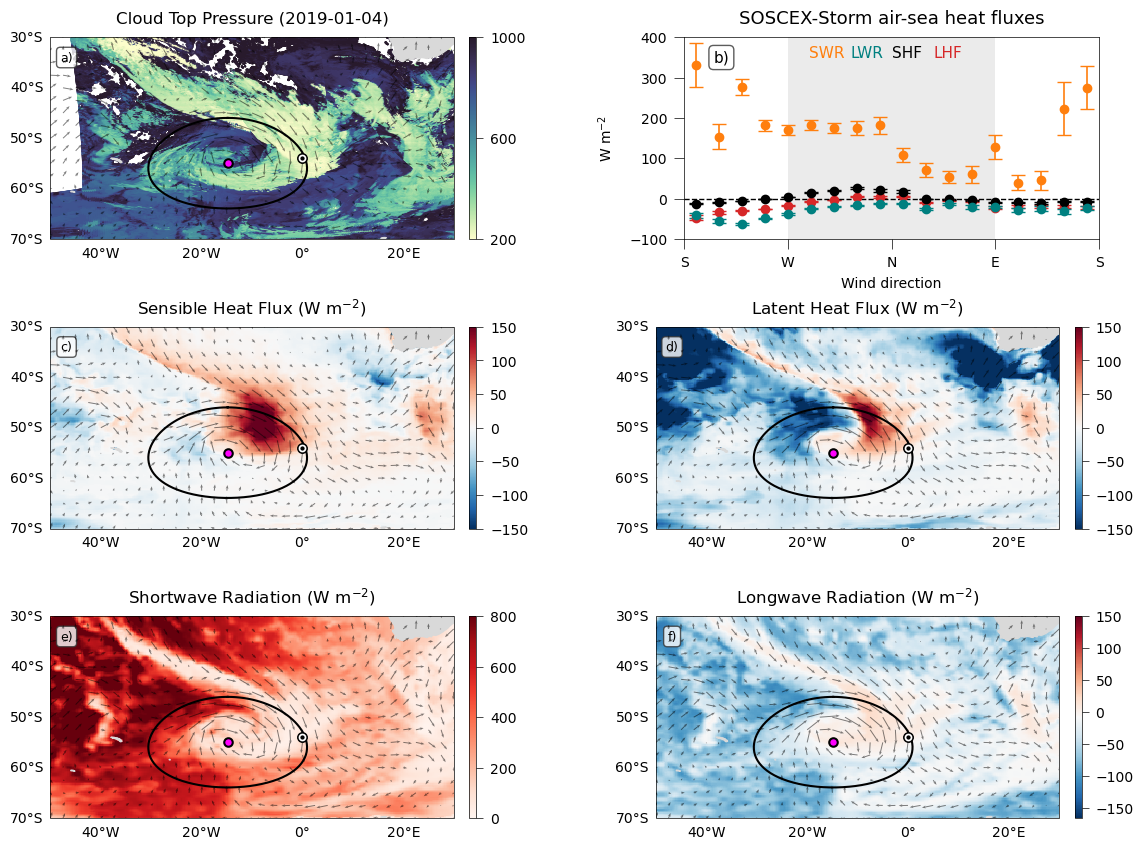

In [ ]:
# plot the maps of CTD and ERA5 data side by side
# fig, ax = plt.subplots(3, 2, figsize=(14, 5),
#                        subplot_kw={'projection': ccrs.PlateCarree()}) # 1 row, 2 columns

def map_features(current_ax, img, lats=lats, lons=lons):
    """Add common map features to the current axis."""
    current_ax.add_feature(cfeature.LAND, zorder=1, edgecolor='black', color='0.85')
    # current_ax.add_feature(cfeature.COASTLINE, zorder=0, color='0.6', linewidth=0.25)
    current_ax.set_extent([-50, 30, -70.01, -29.99], crs=ccrs.PlateCarree())
    gl = current_ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                         linewidth=0, color='gray', alpha=0.5, linestyle='-')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    gl.xlocator = plt.FixedLocator(range(-60, 60, 20))
    gl.ylocator = plt.FixedLocator(range(-70, 0, 10))
    gl.ylabel_padding = 16

    current_ax.scatter(0, -54, s=200, marker='.', c='k', edgecolor='k', lw=0.75, zorder=120, transform=ccrs.PlateCarree())
    current_ax.scatter(0, -54, s=75, marker='.', c='k', edgecolor='w', lw=1.25, zorder=120, transform=ccrs.PlateCarree()) 

    current_ax.scatter(storm_day.lon, storm_day.lat, s=150, marker='.', c='magenta', edgecolor='k', lw=1.5, zorder=120, transform=ccrs.PlateCarree())

    # Colorbar for Plot 1 (placed relative to ax[0])
    cb = plt.colorbar(mappable=img, ax=current_ax, orientation='vertical', pad=0.03, aspect=30)
    cb.ax.tick_params(length=5)

    skip = 10
    current_ax.quiver(era5_day.longitude[::skip], era5_day.latitude[::skip],
                      era5_day.u10[::skip, ::skip], era5_day.v10[::skip, ::skip],
                      scale=5e2, zorder=10, alpha=0.5, headlength=4, headaxislength=3)
    
    current_ax.plot(lons, lats, 'k', lw=1.5, transform=ccrs.Geodetic())

    return current_ax, cb
    
fig = plt.figure(figsize=(12,8.5)) # Adjust figure size as needed

# --- Cloud Top Pressure --- #

current_ax = fig.add_subplot(3, 2, 1, projection=ccrs.PlateCarree())

data_ctp = ds['Cloud_Top_Pressure']

img = current_ax.scatter(ds['lon'], ds['lat'], s=0.1, c=data_ctp, cmap=cmo.deep, vmin=200, vmax=1000, transform=ccrs.PlateCarree())

current_ax, cb = map_features(current_ax, img)

cb.set_ticks([200, 600, 1000])
current_ax.set_title(f'Cloud Top Pressure ({str(ds.time[0].values)[:10]})', fontsize=12, pad=10)
current_ax.text(0.04, 0.9, 'a)', fontsize=9, ha='center', va='center', transform=current_ax.transAxes, bbox=dict(facecolor='white', edgecolor='0.2', alpha=0.8, pad=0.5, boxstyle='round,pad=0.3'))

# --- ERA5 data wind direction --- #

current_ax = fig.add_subplot(3, 2, 2)

current_ax.fill_betweenx(x1=90, x2=270, y=[-100, 400], facecolor='0.85', zorder=0, alpha=0.5)

ms = 6
cs = 5

# Latent heat flux
current_ax.errorbar(wind_dir_grid + 10, lhf_mean_wnd_dir, yerr=lhf_std_wnd_dir, linestyle='None', marker='o', markersize=ms, capsize=cs, zorder=0, color='tab:red', label='$Q_{lat}$')
# Sensible heat flux
current_ax.errorbar(wind_dir_grid + 10, shf_mean_wnd_dir, yerr=shf_std_wnd_dir, linestyle='None', marker='o', markersize=ms, capsize=cs, zorder=0, color='k', label='$Q_{sens}$', alpha=1)

# Latent heat flux
current_ax.errorbar(wind_dir_grid + 10, ssr_mean_wnd_dir, yerr=ssr_std_wnd_dir, linestyle='None', marker='o', markersize=ms, capsize=cs, zorder=0, color='tab:orange', label='$Q_{sw}$')
# Sensible heat flux
current_ax.errorbar(wind_dir_grid + 10, str_mean_wnd_dir, yerr=str_std_wnd_dir, linestyle='None', marker='o', markersize=ms, capsize=cs, zorder=0, color='teal', label='$Q_{lw}$', alpha=1)

# Set axis limits and ticks
current_ax.set_ylim(-100, 400)
current_ax.set_xlim(0, 360)
# ax.yaxis.set_ticks(np.arange(-60, 80, 20))
current_ax.xaxis.set_ticks([0, 90, 180, 270, 360])
current_ax.xaxis.set_ticklabels(['S', 'W', 'N', 'E', 'S'])
current_ax.set_xlabel('Wind direction', labelpad=5)
current_ax.set_ylabel('W m$^{-2}$', labelpad=10)
current_ax.set_title('SOSCEX-Storm air-sea heat fluxes', fontsize=13, pad=10)

# Customize legend
# current_ax.legend(fontsize=11, ncol=4, frameon=True, loc='upper right', bbox_to_anchor=(1, 1.0), handleheight=1, handletextpad=0.5, borderpad=0.3)

# Add a horizontal dashed line
current_ax.axhline(c='k', zorder=0, ls='--', lw=1)

current_ax.text(0.09, 0.9, 'b)', fontsize=11, ha='center', va='center', transform=current_ax.transAxes, bbox=dict(facecolor='white', edgecolor='0.2', alpha=0.8, pad=0.5, boxstyle='round,pad=0.3'))

# set the aspect ratio of the plot
ratio = 0.35
current_ax.set_aspect(ratio)

# add legend to the plot
current_ax.text(0.3, 0.9, 'SWR', fontsize=11, c='tab:orange', transform=current_ax.transAxes)
current_ax.text(0.4, 0.9, 'LWR', fontsize=11, c='teal', transform=current_ax.transAxes)
current_ax.text(0.5, 0.9, 'SHF', fontsize=11, c='k', transform=current_ax.transAxes)
current_ax.text(0.6, 0.9, 'LHF', fontsize=11, c='tab:red', transform=current_ax.transAxes)

# map sensible heat flux
current_ax = fig.add_subplot(3, 2, 3, projection=ccrs.PlateCarree())
img = current_ax.pcolormesh(era5_day.longitude, era5_day.latitude, era5_day.sshf, vmin=-150, vmax=150, cmap='RdBu_r', transform=ccrs.PlateCarree(), rasterized=True)
current_ax.set_title('Sensible Heat Flux (W m$^{-2}$)', fontsize=12, pad=10)
current_ax, cb = map_features(current_ax, img)
current_ax.text(0.04, 0.9, 'c)', fontsize=9, ha='center', va='center', transform=current_ax.transAxes, bbox=dict(facecolor='white', edgecolor='0.2', alpha=0.8, pad=0.5, boxstyle='round,pad=0.3'))

# map latent heat flux
current_ax = fig.add_subplot(3, 2, 4, projection=ccrs.PlateCarree())
img = current_ax.pcolormesh(era5_day.longitude, era5_day.latitude, era5_day.slhf, vmin=-150, vmax=150, cmap='RdBu_r', transform=ccrs.PlateCarree(), rasterized=True)
current_ax.set_title('Latent Heat Flux (W m$^{-2}$)', fontsize=12, pad=10)
current_ax, cb = map_features(current_ax, img)
current_ax.text(0.04, 0.9, 'd)', fontsize=9, ha='center', va='center', transform=current_ax.transAxes, bbox=dict(facecolor='white', edgecolor='0.2', alpha=0.8, pad=0.5, boxstyle='round,pad=0.3'))

# map shortwave radiation
current_ax = fig.add_subplot(3, 2, 5, projection=ccrs.PlateCarree())
img = current_ax.pcolormesh(era5_day.longitude, era5_day.latitude, era5_day.ssr, vmin=0, vmax=800, cmap='Reds', transform=ccrs.PlateCarree(), rasterized=True)
current_ax.set_title('Shortwave Radiation (W m$^{-2}$)', fontsize=12, pad=10)
current_ax, cb = map_features(current_ax, img)
current_ax.text(0.04, 0.9, 'e)', fontsize=9, ha='center', va='center', transform=current_ax.transAxes, bbox=dict(facecolor='white', edgecolor='0.2', alpha=0.8, pad=0.5, boxstyle='round,pad=0.3'))

# map longwave radiation
current_ax = fig.add_subplot(3, 2, 6, projection=ccrs.PlateCarree())
img = current_ax.pcolormesh(era5_day.longitude, era5_day.latitude, era5_day.str, vmin=150, vmax=-150, cmap='RdBu_r', transform=ccrs.PlateCarree(), rasterized=True)
current_ax.set_title('Longwave Radiation (W m$^{-2}$)', fontsize=12, pad=10)
current_ax, cb = map_features(current_ax, img)
current_ax.text(0.04, 0.9, 'f)', fontsize=9, ha='center', va='center', transform=current_ax.transAxes, bbox=dict(facecolor='white', edgecolor='0.2', alpha=0.8, pad=0.5, boxstyle='round,pad=0.3'))
cb.set_ticks(np.arange(-150, 151, 50))

fig.tight_layout()

plt.savefig('/home/mduplessis/projects/duplessis-storms-warming/figs/figure3.png', dpi=600)

In [49]:
import matplotlib.patches as patches # Import patches

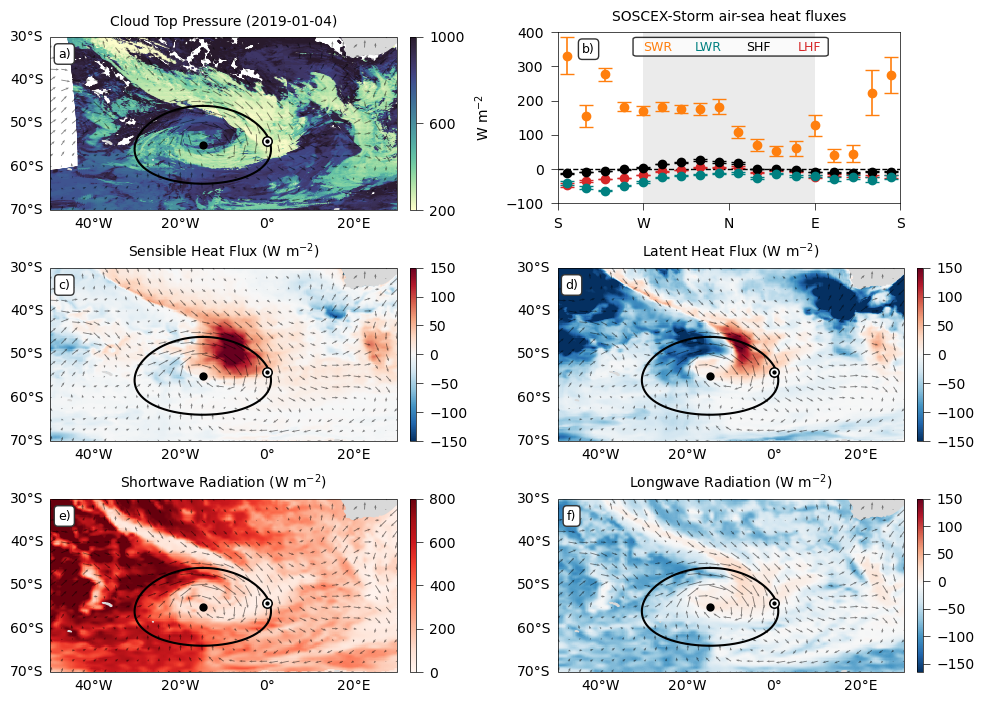

In [69]:
# --- Plotting Code ---

# Define map_features function
def map_features(current_ax, img, lats=lats, lons=lons):
    """Add common map features to the current axis."""
    current_ax.add_feature(cfeature.LAND, zorder=1, edgecolor='black', color='0.85')
    current_ax.set_extent([-50, 30, -70.01, -29.99], crs=ccrs.PlateCarree())
    gl = current_ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                         linewidth=0, color='gray', alpha=0.5, linestyle='-')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    gl.xlocator = plt.FixedLocator(range(-60, 60, 20))
    gl.ylocator = plt.FixedLocator(range(-70, 0, 10))
    gl.ylabel_padding = 16

    current_ax.scatter(0, -54, s=200, marker='.', c='k', edgecolor='k', lw=0.75, zorder=120, transform=ccrs.PlateCarree())
    current_ax.scatter(0, -54, s=75, marker='.', c='k', edgecolor='w', lw=1.25, zorder=120, transform=ccrs.PlateCarree()) 

    current_ax.scatter(storm_day.lon, storm_day.lat, s=20, marker='o', c='k', edgecolor='k', lw=1.5, zorder=120, transform=ccrs.PlateCarree())

    # Colorbar for Plot (placed relative to current_ax)
    cb = plt.colorbar(mappable=img, ax=current_ax, orientation='vertical', pad=0.03, aspect=30, shrink=0.9)
    cb.ax.tick_params(length=5)

    skip = 10
    current_ax.quiver(era5_day.longitude[::skip], era5_day.latitude[::skip],
                      era5_day.u10[::skip, ::skip], era5_day.v10[::skip, ::skip],
                      scale=5e2, zorder=10, alpha=0.5, headlength=4, headaxislength=3)
    
    current_ax.plot(lons, lats, 'k', lw=1.5, transform=ccrs.Geodetic()) # This line seems to be plotting a bounding box, ensure lats/lons are defined for this

    return current_ax, cb

fig = plt.figure(figsize=(12,8.5)) # Adjust figure size as needed

# --- Cloud Top Pressure (Subplot 1) ---
ax1 = fig.add_subplot(3, 2, 1, projection=ccrs.PlateCarree()) # Assign to ax1

data_ctp = ds['Cloud_Top_Pressure']
img_ctp = ax1.scatter(ds['lon'], ds['lat'], s=0.1, c=data_ctp, cmap=cmo.deep, vmin=200, vmax=1000, transform=ccrs.PlateCarree())
ax1, cb_ctp = map_features(ax1, img_ctp, lats=lats, lons=lons) # Pass relevant lats/lons if `map_features` uses them for plotting.
cb_ctp.set_ticks([200, 600, 1000])
ax1.set_title(f'Cloud Top Pressure ({str(ds.time[0].values)[:10]})', fontsize=10, pad=8)
ax1.text(0.04, 0.9, 'a)', fontsize=9, ha='center', va='center', transform=ax1.transAxes, bbox=dict(facecolor='white', edgecolor='0.2', alpha=1, pad=0.5, boxstyle='round,pad=0.3'), zorder=100)

# --- ERA5 data wind direction (Subplot 2) ---
ax2 = fig.add_subplot(3, 2, 2) # Assign to ax2

# Get the current position of ax2
box_ax2 = ax2.get_position()

# Calculate the new position for ax2 (shift left)
# Adjust 'left' value (e.g., reduce it by 0.05 to shift left)
# The 'width' and 'height' can also be adjusted if needed, but 'left' is key for horizontal shift.
new_left = box_ax2.x0 - 0.0 # Experiment with this value to get desired alignment
new_bottom = box_ax2.y0 + 0.018 # Experiment with this value to get desired alignment
new_width = box_ax2.width * 0.81 # Shrink width to 80% of original
new_height = box_ax2.height * 0.9 # Shrink height to 90% of original (optional)

ax2.set_position([new_left, new_bottom, new_width, new_height])

ax2.tick_params(axis='both',       # Affects both x and y axis ticks
                which='major',     # Affects major ticks (you can also use 'minor' or 'both')
                length=5)

ax2.fill_betweenx(x1=90, x2=270, y=[-100, 400], facecolor='0.85', zorder=0, alpha=0.5)
ms = 6
cs = 5

ax2.errorbar(wind_dir_grid + 10, lhf_mean_wnd_dir, yerr=lhf_std_wnd_dir, linestyle='None', marker='o', markersize=ms, capsize=cs, zorder=0, color='tab:red', label='$Q_{lat}$')
ax2.errorbar(wind_dir_grid + 10, shf_mean_wnd_dir, yerr=shf_std_wnd_dir, linestyle='None', marker='o', markersize=ms, capsize=cs, zorder=0, color='k', label='$Q_{sens}$', alpha=1)
ax2.errorbar(wind_dir_grid + 10, ssr_mean_wnd_dir, yerr=ssr_std_wnd_dir, linestyle='None', marker='o', markersize=ms, capsize=cs, zorder=0, color='tab:orange', label='$Q_{sw}$')
ax2.errorbar(wind_dir_grid + 10, str_mean_wnd_dir, yerr=str_std_wnd_dir, linestyle='None', marker='o', markersize=ms, capsize=cs, zorder=0, color='teal', label='$Q_{lw}$', alpha=1)

ax2.set_ylim(-100, 400)
ax2.set_xlim(0, 360)
ax2.xaxis.set_ticks([0, 90, 180, 270, 360])
ax2.xaxis.set_ticklabels(['S', 'W', 'N', 'E', 'S'])
# ax2.set_xlabel('Wind direction', labelpad=5)
ax2.set_ylabel('W m$^{-2}$', labelpad=10)
ax2.set_title('SOSCEX-Storm air-sea heat fluxes', fontsize=10, pad=8)

ax2.axhline(c='k', zorder=0, ls='--', lw=1)

ax2.text(0.09, 0.9, 'b)', fontsize=9, ha='center', va='center', transform=ax2.transAxes, bbox=dict(facecolor='white', edgecolor='0.2', alpha=1, pad=0.5, boxstyle='round,pad=0.3'), zorder=100)

ratio = 0.5
ax2.set_box_aspect(ratio)

# --- Add the single bounding box around the text elements ---
# Coordinates of the box in axes fraction (0 to 1)
# You'll need to fine-tune these 'left', 'bottom', 'width', 'height' values
# after adjusting subplot size and position.
# These are estimates based on your text positions:
box_left = 0.23 # Start slightly left of the 'SWR' text (0.25)
box_bottom = 0.87 # Start slightly below the text's vertical center (0.9)
box_width = 0.55 # Span from 0.23 to approx 0.73 to cover 'LHF' text (0.70)
box_height = 0.089 # A small height to cover the text.

# Create the FancyBboxPatch for rounded corners
rect = patches.FancyBboxPatch(
    (box_left, box_bottom), # (x,y) lower-left corner in axes coordinates
    box_width, box_height, # width, height in axes coordinates
    boxstyle="round,pad=0.01", # Rounded corners with small internal padding
    facecolor='white',
    edgecolor='black', # You can set this to 'none' if you don't want a border
    alpha=0.8,
    transform=ax2.transAxes, # Crucial: tells matplotlib to use axes coordinates
    zorder=9 # Ensure the box is behind the text (default text zorder is 10)
)

# Add the patch to ax2
ax2.add_patch(rect)

ax2.text(0.25, 0.89, 'SWR', fontsize=9, c='tab:orange', transform=ax2.transAxes, zorder=10)
ax2.text(0.4, 0.89, 'LWR', fontsize=9, c='teal', transform=ax2.transAxes, zorder=10)
ax2.text(0.55, 0.89, 'SHF', fontsize=9, c='k', transform=ax2.transAxes, zorder=10)
ax2.text(0.70, 0.89, 'LHF', fontsize=9, c='tab:red', transform=ax2.transAxes, zorder=10)

# --- map sensible heat flux (Subplot 3) ---
ax3 = fig.add_subplot(3, 2, 3, projection=ccrs.PlateCarree())
img_shf = ax3.pcolormesh(era5_day.longitude, era5_day.latitude, era5_day.sshf, vmin=-150, vmax=150, cmap='RdBu_r', transform=ccrs.PlateCarree(), rasterized=True)
ax3.set_title('Sensible Heat Flux (W m$^{-2}$)', fontsize=10, pad=8)
ax3, cb_shf = map_features(ax3, img_shf, lats=lats, lons=lons)
ax3.text(0.04, 0.9, 'c)', fontsize=9, ha='center', va='center', transform=ax3.transAxes, bbox=dict(facecolor='white', edgecolor='0.2', alpha=1, pad=0.5, boxstyle='round,pad=0.3'), zorder=100)

# --- map latent heat flux (Subplot 4) ---
ax4 = fig.add_subplot(3, 2, 4, projection=ccrs.PlateCarree())
img_lhf = ax4.pcolormesh(era5_day.longitude, era5_day.latitude, era5_day.slhf, vmin=-150, vmax=150, cmap='RdBu_r', transform=ccrs.PlateCarree(), rasterized=True)
ax4.set_title('Latent Heat Flux (W m$^{-2}$)', fontsize=10, pad=8)
ax4, cb_lhf = map_features(ax4, img_lhf, lats=lats, lons=lons)
ax4.text(0.04, 0.9, 'd)', fontsize=9, ha='center', va='center', transform=ax4.transAxes, bbox=dict(facecolor='white', edgecolor='0.2', alpha=1, pad=0.5, boxstyle='round,pad=0.3'), zorder=100)

# --- map shortwave radiation (Subplot 5) ---
ax5 = fig.add_subplot(3, 2, 5, projection=ccrs.PlateCarree())
img_ssr = ax5.pcolormesh(era5_day.longitude, era5_day.latitude, era5_day.ssr, vmin=0, vmax=800, cmap='Reds', transform=ccrs.PlateCarree(), rasterized=True)
ax5.set_title('Shortwave Radiation (W m$^{-2}$)', fontsize=10, pad=8)
ax5, cb_ssr = map_features(ax5, img_ssr, lats=lats, lons=lons)
ax5.text(0.04, 0.9, 'e)', fontsize=9, ha='center', va='center', transform=ax5.transAxes, bbox=dict(facecolor='white', edgecolor='0.2', alpha=1, pad=0.5, boxstyle='round,pad=0.3'), zorder=100)

# --- map longwave radiation (Subplot 6) ---
ax6 = fig.add_subplot(3, 2, 6, projection=ccrs.PlateCarree())
img_str = ax6.pcolormesh(era5_day.longitude, era5_day.latitude, era5_day.str, vmin=150, vmax=-150, cmap='RdBu_r', transform=ccrs.PlateCarree(), rasterized=True)
ax6.set_title('Longwave Radiation (W m$^{-2}$)', fontsize=10, pad=8)
ax6, cb_str = map_features(ax6, img_str, lats=lats, lons=lons)
cb_str.set_ticks(np.arange(-150, 151, 50)) # Note: vmin > vmax, so ticks might be weird, consider vmax/vmin order
ax6.text(0.04, 0.9, 'f)', fontsize=9, ha='center', va='center', transform=ax6.transAxes, bbox=dict(facecolor='white', edgecolor='0.2', alpha=1, pad=0.5, boxstyle='round,pad=0.3'), zorder=100)


# fig.tight_layout() # Call tight_layout last, as it can override set_position if not careful.
                   # Alternatively, for fine-grained control, you might adjust padding manually.
# For tight_layout to respect manual position changes, it's sometimes best to set
# `pad` to 0 or use `w_pad`, `h_pad` manually or omit tight_layout entirely and use `set_position` for all.

plt.savefig('/home/mduplessis/projects/duplessis-storms-warming/figs/figure3.png', dpi=600)
plt.show()